In [5]:
#relevant imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os 
import glob

In [6]:
# #aggregating collected data
# paths = glob.glob('./BTC/BTC*.zip')

# full_dataset = None

# for i in range(len(paths)):
#     if full_dataset is None:
#         full_dataset = pd.read_csv('BTC/BTC_Book_' + str(i) + '.zip', 
#                                    compression = 'zip', index_col = 0, parse_dates = True)
#     else:
#         app_data = pd.read_csv('BTC/BTC_Book_' + str(i) + '.zip', 
#                                compression = 'zip', index_col = 0, parse_dates = True)
#         full_dataset = full_dataset.append(app_data)
        
# full_dataset.head(1)        

full_dataset = pd.read_csv('BTC/BTC_Book_0.zip', compression = 'zip', index_col = 0, parse_dates = True)

In [7]:
#reorder data sets
prices = full_dataset[full_dataset.columns[1::3]]
p_cols = list(np.flip(prices.columns.values[:50])) + list(prices.columns.values[50:])
prices = prices[p_cols]

sizes = full_dataset[full_dataset.columns[2::3]]
s_cols = list(np.flip(sizes.columns.values[:50])) + list(sizes.columns.values[50:])
sizes = sizes[s_cols]

trades = full_dataset[full_dataset.columns[3::3]]
t_cols = list(np.flip(trades.columns.values[:50])) + list(trades.columns.values[50:])
trades = trades[t_cols]

(49971, 30, 100)


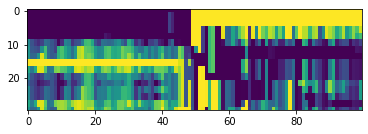

In [8]:
from sklearn.preprocessing import MinMaxScaler

def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

time_slices = rolling_window(prices.values, 30)
print(time_slices.shape)

new_slices = np.zeros(time_slices.shape)

time_scaler = MinMaxScaler(feature_range=(0,1))
for i in range(time_slices.shape[0]):
  img = time_slices[i]
  time_scaler.fit(img)
  img_tr = time_scaler.transform(img)
  new_slices[i,:,:] = img_tr.copy()


plt.imshow(new_slices[0])

(50000,)
(50000,)
(50000,)


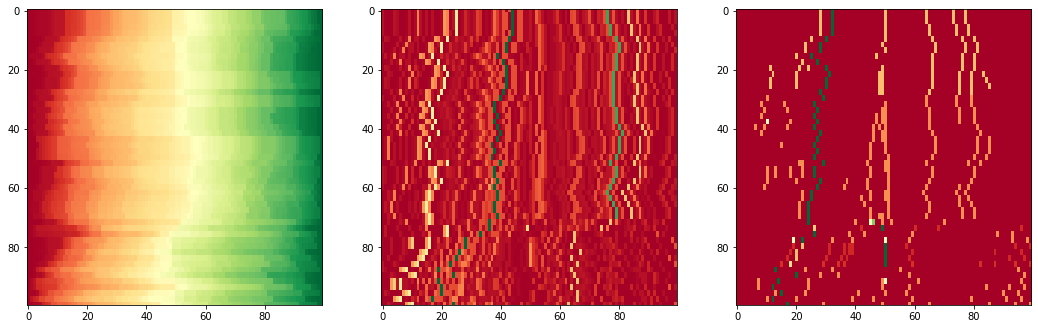

In [9]:
from sklearn.preprocessing import MinMaxScaler

#scale prices
p_scaler = MinMaxScaler(feature_range=(0,1))
p_scaler.fit(prices.T)
print(p_scaler.min_.shape)
price_tr = p_scaler.transform(prices.T).T

#scale sizes
s_scaler = MinMaxScaler(feature_range=(0,1))
s_scaler.fit(sizes.T)
print(s_scaler.min_.shape)
size_tr = s_scaler.transform(sizes.T).T

#scale trades
t_scaler = MinMaxScaler(feature_range=(0,1))
t_scaler.fit(trades.T)
print(t_scaler.min_.shape)
trade_tr = t_scaler.transform(trades.T).T


#plot example
start = 0
window = 100
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6))
ax[0].imshow(price_tr[start:start + window], cmap = 'RdYlGn')
ax[1].imshow(size_tr[start:start + window], cmap = 'RdYlGn')
ax[2].imshow(trade_tr[start:start + window], cmap = 'RdYlGn')

In [11]:
# price_roll.shape
# size_roll.shape
# trade_roll.shape

In [12]:
#setting up X for training
def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

start = 0
window = 50000

price_roll = rolling_window(price_tr[start:start+window], 30)
size_roll = rolling_window(size_tr[start:start+window], 30)
trade_roll = rolling_window(trade_tr[start:start+window], 30)
time_roll = new_slices[start:start+price_roll.shape[0]]

total = np.stack((price_roll, size_roll, trade_roll, time_roll),axis = -1)
total.shape

(49971, 30, 100, 4)

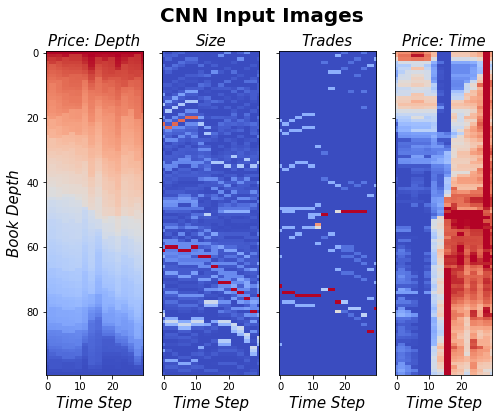

In [64]:
sample = 60
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (8, 6), sharex = True, sharey=True)
ax[0].imshow(np.flip(total[sample][:,:,0].T,axis = 0), cmap = plt.cm.coolwarm)
ax[1].imshow(np.flip(total[sample][:,:,1].T,axis = 0), cmap = plt.cm.coolwarm)
ax[2].imshow(np.flip(total[sample][:,:,2].T,axis = 0), cmap = plt.cm.coolwarm)
ax[3].imshow(total[sample][:,:,3].T, cmap = plt.cm.coolwarm)

fig.suptitle("CNN Input Images", fontsize = 20, weight = 'bold')
ax[0].set_title("Price: Depth", fontsize = 15, style = 'italic')
ax[1].set_title("Size", fontsize = 15, style = 'italic')
ax[2].set_title("Trades", fontsize = 15, style = 'italic')
ax[3].set_title("Price: Time", fontsize = 15, style = 'italic')
ax[0].set_xlabel("Time Step", fontsize = 15, style = 'italic')
ax[1].set_xlabel("Time Step", fontsize = 15, style = 'italic')
ax[2].set_xlabel("Time Step", fontsize = 15, style = 'italic')
ax[3].set_xlabel("Time Step", fontsize = 15, style = 'italic')

ax[0].set_ylabel("Book Depth", fontsize = 15, style = 'italic')

fig.savefig("CNN_Images.png")

In [59]:
total[sample][:,:,3][:,51]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.16302766, 0.16302766, 0.55676856, 0.55676856,
       0.99708879, 0.99708879, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99636099, 0.99636099, 0.89519651])

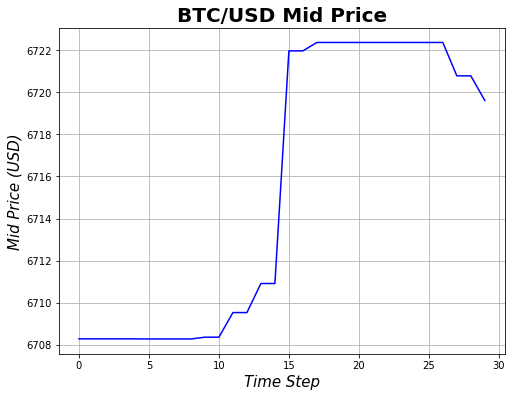

In [61]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.plot(np.arange(0,30),mid_price['mid_price'][start+sample:start+sample+30].values, color = 'blue')
ax.set_title("BTC/USD Mid Price", fontsize = 20, weight = 'bold')
ax.set_xlabel("Time Step", fontsize = 15, style = 'italic')
ax.set_ylabel("Mid Price (USD)", fontsize = 15, style = 'italic')
ax.grid('on')

fig.savefig("CNN_Images_MP.png")

In [30]:
#Setting up Targets for training
from sklearn.preprocessing import OneHotEncoder

mid_price = pd.DataFrame((prices['Bid_1_Price'] + prices['Ask_1_Price'])/2 ,columns = ['mid_price'])
mid_price['target'] = mid_price['mid_price'].diff(1).shift(-1)
sd = mid_price['target'].std()

def return_cat(x, stdev):
    if x > (0 + stdev):
        return 1
    if x < (0 - stdev):
        return -1
    else:
        return 0

mid_price['target_cat'] = mid_price['target'].apply(return_cat, args = (sd,)) #not NAN for indices 0 - 49998 - last is nan
mid_price = mid_price.dropna()
    
encoder = OneHotEncoder()
encoder.fit(mid_price['target_cat'].values.reshape(-1,1))
target_one_hot = encoder.transform(mid_price['target_cat'].values.reshape(-1,1)).toarray()
target_one_hot = target_one_hot[start:start+window]
print(target_one_hot.shape)

(49999, 3)


In [90]:
#Setting Train Sets
X = total[:len(total)-1] #remove last since no prediction
print(X.shape)

Y = target_one_hot[29:] #no predictions for indicies 0 -> 98 (99 steps), index 99 has first 1 step ahead
print(Y.shape)

# X_train = X[:40000]
# Y_train = Y[:40000]

# X_test = X[40000:]
# Y_test = Y[40000:]

(209336, 30, 100, 4)
(209336, 3)


In [84]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
rus.fit_resample(X[:,:,0,0], Y)

Y_res = Y[rus.sample_indices_]
X_res = X[rus.sample_indices_]

print(Y_res.shape)
print(X_res.shape)

(6771, 3)
(6771, 30, 100, 4)


In [91]:
np.save('Train_Test_Data/CNN/test_cnn_1_X.npy', X)
np.save('Train_Test_Data/CNN/test_cnn_1_Y.npy', Y)

In [92]:
X_test = np.load('Train_Test_Data/CNN/test_cnn_1_X.npy')
Y_test = np.load('Train_Test_Data/CNN/test_cnn_1_Y.npy')

In [100]:
X_test.shape

(209336, 30, 100, 4)

In [102]:
X_test.shape
np.save('Train_Test_Data/CNN/test_cnn_1_X.npy', X_test[:50000])
np.save('Train_Test_Data/CNN/test_cnn_1_Y.npy', Y_test[:50000])